# Deploying trained Le Net model

In [1]:
%matplotlib inline
import numpy as np

caffe_root = '../../../caffe/'

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

/home/mily/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import os
np_loaded_data_file = '../data/train_data_cleaned.npz'
if not os.path.isfile(np_loaded_data_file):
    print "%s does not exist. See facial_recog_kaggle.ipynb" % np_loaded_data_file
else:
    print "loading %s" % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    print "loaded: ", npzfile.files
    X_train_clean_cv, y_train_clean_cv = npzfile['X_train_clean_cv'], npzfile['y_train_clean_cv']
    X_val_clean_cv, y_val_clean_cv = npzfile['X_val_clean_cv'], npzfile['y_val_clean_cv']
    feature_labels = npzfile['feature_labels']
    print X_train_clean_cv.shape, y_train_clean_cv.shape
    print X_val_clean_cv.shape, y_val_clean_cv.shape


loading ../data/train_data_cleaned.npz
loaded:  ['X_val_clean_cv', 'y_val_clean_cv', 'y_train_clean_cv', 'feature_labels', 'X_train_clean_cv']
(1628, 1, 96, 96) (1628, 30)
(512, 1, 96, 96) (512, 30)


In [12]:
net = caffe.Net('good_models/test_net__b_lr_5.41e-03__reg_param_4.64e-03__batch_size_64_drop_75.prototxt',
                'good_models/lenet_trained__b_lr_5.41e-03__reg_param_4.64e-03__batch_size_64_drop_75.caffemodel',
                caffe.TEST)
batch_size = 64

## Sanity Checks

In [13]:
[(k, v[0].data.shape, v[1].data.shape) for k, v in net.params.items()]

[('conv1', (20, 1, 5, 5), (20,)),
 ('conv2', (50, 20, 5, 5), (50,)),
 ('fc1', (500, 22050), (500,)),
 ('score', (30, 500), (30,))]

In [63]:
def euclidean_loss(a, b):
    batch_size, num_labels = a.shape
    
    return np.sum((a-b)**2) / float(batch_size * 2)
    
# Make sure train error and validation error are as expected. 
train_size = X_train_clean_cv.shape[0]
val_size = X_val_clean_cv.shape[0]
num_labels = y_train_clean_cv.shape[1]


input_size = 96

zero_pad = np.zeros(( batch_size - (train_size % batch_size), 1, input_size, input_size))
X_train = np.append(X_train_clean_cv, zero_pad, axis=0)
num_batches = X_train.shape[0] // batch_size

# X_train = np.random.randn(np.prod(X_train.shape)).reshape(X_train.shape)

zero_pad = np.zeros(( batch_size - (train_size % batch_size), num_labels))
y_train = np.append(y_train_clean_cv, zero_pad, axis=0)
# num_batches = 1
out_train = np.zeros((X_train.shape[0], 30) )

train_error = 0
# print num_batches
# print X_train.shape[0]
# print train_size
num_batches = 1

for it in range(num_batches):
    it_range = range(it*batch_size,it*batch_size+batch_size)
    net.blobs['data'].data[...] = X_train[it_range]
    
    out_test = net.forward()
    
    out = net.blobs['score'].data
    out_train[it_range, :] = out
    
#     print net.blobs['fc1'].data.shape
#     print net.blobs['score'].data.shape
#     print out_test
    print "data"
    print net.blobs['data'].data.shape
    print net.blobs['data'].data[0:5, 0, 0:5, 0]
    
    print "conv1"
    print net.blobs['conv1'].data.shape
    print net.blobs['conv1'].data[0:5, 0, 0:5, 0]
    
    print "conv1 weights"
    print net.params['conv1'][0].data.shape
    print net.params['conv1'][0].data[0:2][0:5]
    

    print "pool1"
    print net.blobs['pool1'].data.shape
    print net.blobs['pool1'].data[0:5, 0, 0:5, 0]
    
    
    print "conv2"
    print net.blobs['conv2'].data.shape
    print net.blobs['conv2'].data[0:5, 0, 0:5, 0]
    
    print "conv2 weights"
    print net.params['conv2'][0].data.shape
    print net.params['conv2'][0].data[0:2, 0:2, 0:5, 0]
    
    print "pool2"
    print net.blobs['pool2'].data.shape
    print net.blobs['pool2'].data[0:5, 0, 0:5, 0]
    
    print "fc1"
    print net.blobs['fc1'].data[0:2,0:5]
    
    print "score"
    print net.blobs['score'].data[0:2]
    
    train_error += euclidean_loss(out, y_train[it_range])
train_error = train_error / float(num_batches * batch_size)  


out_train_clean_cv = out_train[0:train_size]
print train_error



data
(64, 1, 96, 96)
[[  74.15532684   75.15532684   75.15532684   74.15532684   75.15532684]
 [ -42.84467316  -41.84467316  -30.84467506  -26.84467506  -37.84467316]
 [  63.15532684   60.15532684   61.15532684   61.15532684   58.15532684]
 [-113.84467316 -112.84467316 -116.84467316 -116.84467316 -116.84467316]
 [  96.15532684   96.15532684   98.15532684   97.15532684   96.15532684]]
conv1
(64, 20, 92, 92)
[[ 24.780653    25.98588371  25.6966629   25.00029564  23.69001579]
 [ 24.30462456  10.71406937   0.           0.           0.        ]
 [ 18.93813705  18.05801392  18.92779541  19.32902145  17.84712791]
 [  0.           0.           0.           0.           0.        ]
 [ 32.00254059  30.92790413  31.12981796  36.03961182  44.31597137]]
conv1 weights
(20, 1, 5, 5)
[[[[-0.01245944  0.06087019  0.0708628   0.09443135 -0.12588552]
   [ 0.09518977  0.08146539  0.02491388  0.17704998 -0.27029765]
   [-0.02885191  0.34146371 -0.31084451 -0.23278198  0.12988514]
   [ 0.29838136  0.2909032

In [15]:
batch_size = 64
num_batches = val_size/ batch_size
val_error = 0
out_val_clean_cv = np.zeros_like(y_val_clean_cv)

for it in range(num_batches):
    it_range = range(it*batch_size,it*batch_size+batch_size)
    net.blobs['data'].data[...] = X_val_clean_cv[it_range]
    net.forward()
    out = net.blobs['score'].data
    out_val_clean_cv[it_range, :] = out
    
    val_error += euclidean_loss(out, y_val_clean_cv[it_range])
val_error = val_error / float(num_batches * batch_size)  
print val_error

2.29946921501


[[1339 1141   75 1583]
 [ 373  789 1376 1215]
 [ 842  873  676  621]
 [1540 1261   47  174]]


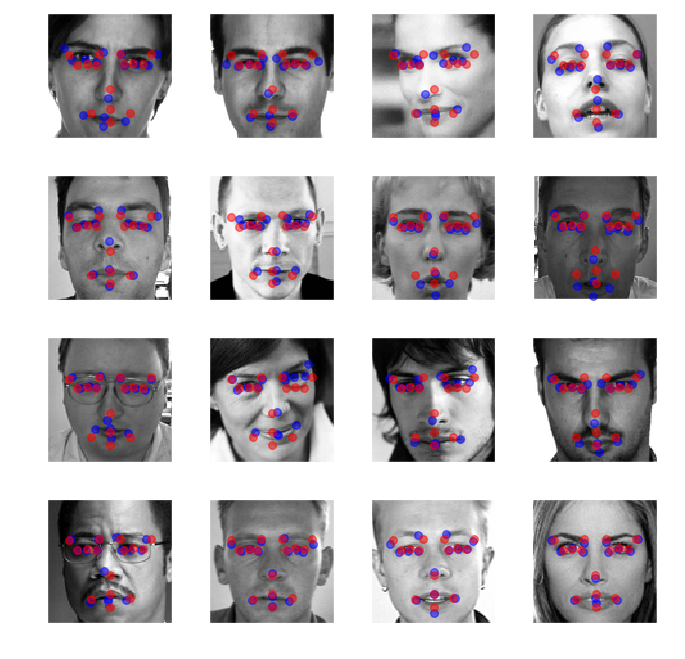

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Visualize
N_img_x = 4
N_img_y = 4
sel_idx = np.random.choice(X_train_clean_cv.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_train_clean_cv[i].reshape(96, 96)
        b = y_train_clean_cv[i]
        b_x = b[0::2]
        b_y = b[1::2]
        
        o = out_train_clean_cv[i]
        o_x = o[0::2]
        o_y = o[1::2]
        

        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(a)
        plt.scatter(b_x, b_y, s=30, alpha=0.5, color='blue')
        plt.scatter(o_x, o_y, s=30, alpha=0.5, color='red')
        plt.gca().axis('off')
plt.show()

[[ 694 1443  724 1554]
 [1544 1199 1553 1028]
 [ 780 1224  553 1579]
 [ 116  684   57  846]]


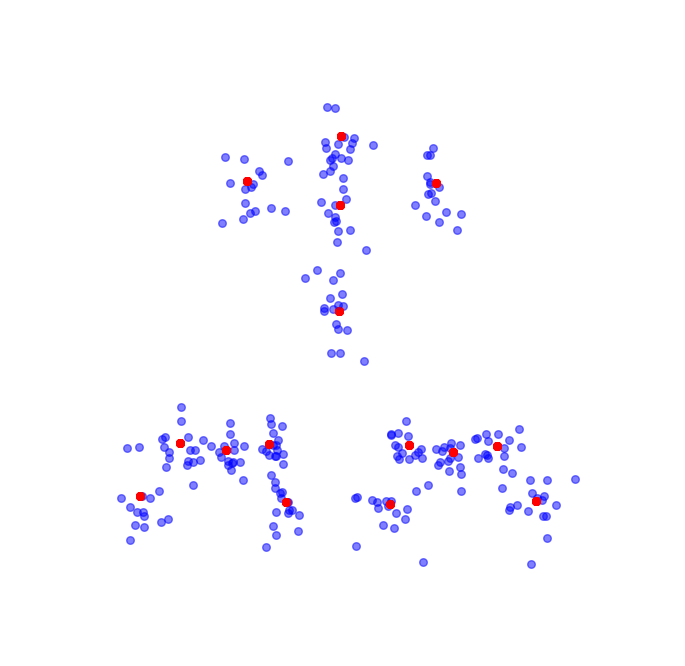

In [23]:
# check spread/ distribution

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Visualize
N_img_x = 4
N_img_y = 4
sel_idx = np.random.choice(X_train_clean_cv.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_train_clean_cv[i].reshape(96, 96)
        b = y_train_clean_cv[i]
        b_x = b[0::2]
        b_y = b[1::2]
        
        o = out_train_clean_cv[i]
        o_x = o[0::2]
        o_y = o[1::2]
        

#         plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
#         plt.imshow(a)
        plt.scatter(b_x, b_y, s=30, alpha=0.5, color='blue')
        plt.scatter(o_x, o_y, s=30, alpha=0.5, color='red')
        plt.gca().axis('off')
plt.show()

[[ 27 216 322 104]
 [500 134   0 253]
 [243 167 127   9]
 [ 28 326  44 370]]


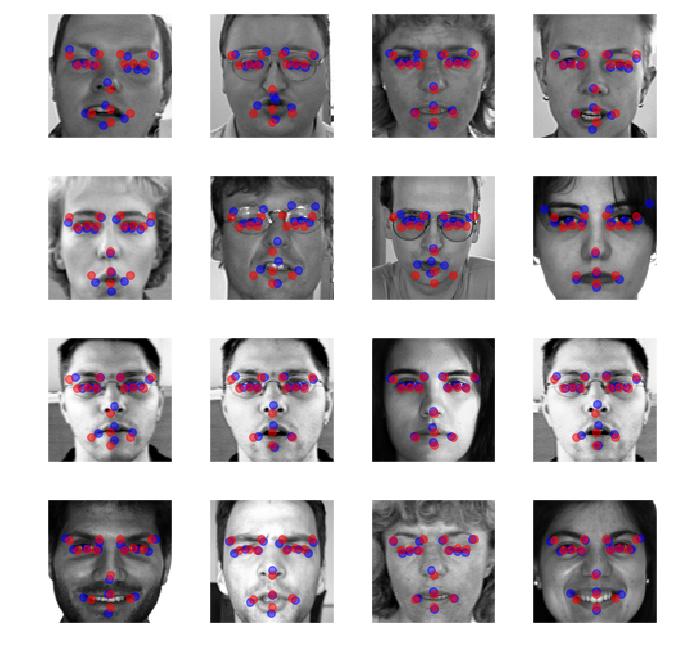

In [17]:
# Visualize
N_img_x = 4
N_img_y = 4
sel_idx = np.random.choice(X_val_clean_cv.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_val_clean_cv[i].reshape(96, 96)
        b = y_val_clean_cv[i]
        b_x = b[0::2]
        b_y = b[1::2]
        
        o = out_val_clean_cv[i]
        o_x = o[0::2]
        o_y = o[1::2]
        

        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(a)
        plt.scatter(b_x, b_y, s=30, alpha=0.5, color='blue')
        plt.scatter(o_x, o_y, s=30, alpha=0.5, color='red')
        plt.gca().axis('off')
plt.show()

In [19]:
import os.path
import pandas as pd

np_loaded_data_file = "../data/test_data.npz"
if not os.path.isfile(np_loaded_data_file):
    print "reading data ..."
    try:
        df=pd.read_csv('../data/test.csv', sep=',')
    except:
        print "Download test.csv from kaggle website"
    input_test = df.values
    
    X_test = input_test[:, 1]
    
    templist = []
    for i in range(X_test.shape[0]):
        templist.append([int(s) for s in X_test[i].split()])
    X_test = np.array(templist)
    
    X_test = X_test.astype(float)
    np.savez(np_loaded_data_file, X_test=X_test)
    print "saved %s ...." % np_loaded_data_file
else:
    print "training data %s exists. loading... " % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    X_test = npzfile['X_test']

training data ../data/test_data.npz exists. loading... 


In [20]:
X_test = X_test - np.mean(X_test)
num_test_images = X_test.shape[0]

input_size = 96
X_test = X_test.reshape(-1, 1, input_size, input_size)

zero_pad = np.zeros(( batch_size - (num_test_images % batch_size), 1, input_size, input_size))

X_test = np.append(X_test, zero_pad, axis=0)


num_batches = X_test.shape[0] // batch_size
# num_batches = 1
out_test = np.zeros((X_test.shape[0], 30) )

for it in range(num_batches):
    it_range = range(it*batch_size,it*batch_size+batch_size)
    net.blobs['data'].data[...] = X_test[it_range]
    net.forward()
    out = net.blobs['score'].data
    out_test[it_range, :] = out
    
out_test = out_test[0:num_test_images]


[[1100 1672 1623  467]
 [ 647   65 1422 1642]
 [ 474  782  868   37]
 [ 206 1378 1711    0]]


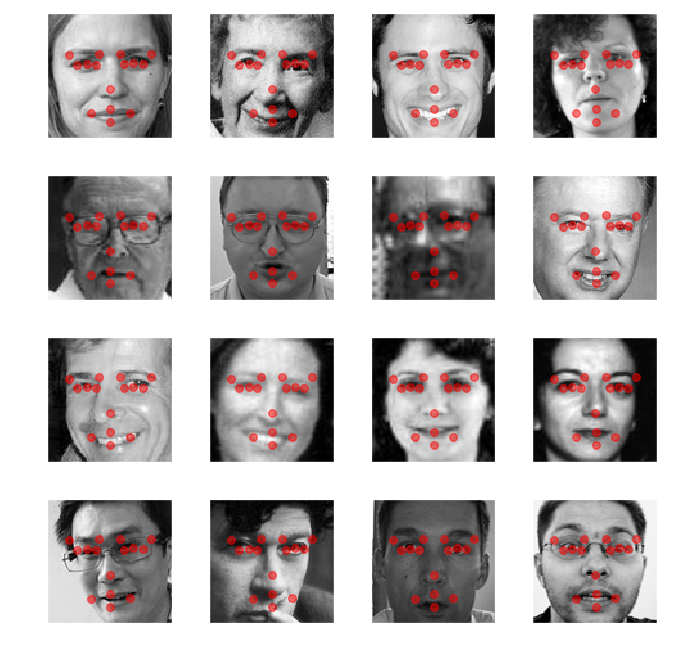

In [21]:
# Visualize
N_img_x = 4
N_img_y = 4
sel_idx = np.random.choice(X_test.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_test[i].reshape(96, 96)
        
        
        o = out_test[i]
        o_x = o[0::2]
        o_y = o[1::2]
        

        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(a)
        plt.scatter(o_x, o_y, s=30, alpha=0.5, color='red')
        plt.gca().axis('off')
plt.show()

In [22]:
feature_label_lookup_table = dict(zip(feature_labels[0:30], range(30)))
try:
    df=pd.read_csv('../data/IdLookupTable.csv', sep=',')
except:
    print "Download IdLookupTable.csv from kaggle website"
input_test = df.values

row_ids = input_test[:, 0]
image_ids = input_test[:, 1]
feature_names = input_test[:, 2]
locations = np.zeros(image_ids.shape[0])

for row_id, image_id, feature_name in zip(row_ids, image_ids, feature_names):
    locations[row_id-1] = out_test[image_id, feature_label_lookup_table[feature_name]]
    

df_save = pd.DataFrame(index=row_ids, data=locations, columns=['Location'], index_label='RowId')
df_save.to_csv('../data/submission_20161017.csv')

IndexError: index 1783 is out of bounds for axis 0 with size 1783